<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Analysis of the 2004 Sumatra-Andaman earthquake</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Part B: Data Download</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Andita Aiman
* Tomy Gunawan
* Angel Ling
---

Based on *GEOS 626: Applied Seismology from Carl Tape*

The goal of this notebook is to download and choose the right data for Part B.

In [1]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.signal.invsim import cosine_taper
from obspy.clients.fdsn import Client
import matplotlib.pylab as plt
from matplotlib.mlab import detrend
import numpy as np
import os
from os import path
import pandas as pd
from datetime import datetime 
plt.rcParams['figure.figsize'] = 15,7

In [6]:
# Setting up parameters for getting waveforms
client = Client("IRIS")
t = UTCDateTime("2004-12-26T00:58:53.0")   # origin time of Sumatra earthquake
starttime = t-(1*24*60*60)                 # 1 day before the the origin time
endtime   = t+(9*24*60*60)                 # 9 days after the the origin time

# Setting up folders for saving data
directory = "./data"
directory1 = "./fft"
if not path.exists(directory):  # If data directory doesn't exist, it will create one
    os.makedirs(directory)
if not path.exists(directory1): # If fft directory doesn't exist, it will create one
    os.makedirs(directory1)

In [ ]:
# Measure the download time
start = datetime.now()

# Downloading waveform data from the station list 1, 2, and 3
# Please comment out the list you want to download 

#sta_list = pd.read_csv('stationlist1.csv', sep=',', header=None)      # List 1 (AAK-HKT)
#sta_list = pd.read_csv('stationlist2.csv', sep=',', header=None)      # List 2 (HNR-PFO)
#sta_list = pd.read_csv('stationlist3.csv', sep=',', header=None)      # List 3 (PMSA-YSS)

sta_fname = sta_list[1]   # list of file name
sta_code  = sta_list[2]   # list of station name
sta_chan  = sta_list[3]   # list of SEED channel
sta_loc   = sta_list[4]   # list of SEED location
sta_net   = sta_list[5]   # list of station network

# Download and save the raw waveform in the data directory
for i in range(len(sta_code)):
    st = client.get_waveforms(sta_net[i], sta_code[i], sta_loc[i], sta_chan[i], 
                              starttime, endtime, attach_response=True)     # get the waveform
    st.resample(1.0)                                                        # resample the sampling rate
    st.merge(method=1, fill_value=0)                                        # merge the traces, fill gaps with 0
    st.write(path.join(directory, sta_fname[i]), format = 'SAC')    # write and save the stream into SAC format
    print (st)

# Print download time
d = datetime.now() - start
print (d, " s")

1 Trace(s) in Stream:
II.AAK.00.LHZ | 2004-12-25T00:58:53.857400Z - 2005-01-04T00:58:51.857400Z | 1.0 Hz, 863999 samples


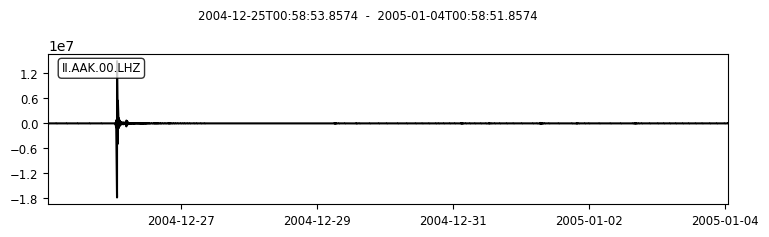

In [9]:
# Check the downloaded signal
# stationlist.csv provides the full list of stations used in this exercise
sta_list1 = pd.read_csv('stationlist.csv', sep=',', header=None)
sta_fname1 = sta_list1[1]                      # list of file name
st_check = read(path.join(directory, sta_fname1[0])) # Enter the number of the station you want to check (start from 0)
print (st_check)
st_check.plot()

In [ ]:
# Perform fft and save the result in the FFT folder

dur_s = 10*24*60*60    # convert 10 days into s
taper_percentage = 0.005
taper = cosine_taper(dur_s,taper_percentage)

# Read and merge all data into single stream object
# Perform tapering, detrending 
for i in range (len(sta_fname)):
    st_new = read(path.join(directory, sta_fname[i]),header=None)
    tr = np.array(st_new.copy()[0])
    t = Trace(tr).stats.starttime
    tr_trim = np.array(Trace(tr).trim(t,t+dur_s-1, pad=True, fill_value=0)) # Make sure they have the same no. of sample
    tr_td = detrend(tr_trim * taper, 'linear') # Taper and Detrend
    tr_fft = Trace(np.array(np.fft.rfft(tr_td)))
    tr_fft.write(path.join(directory1, sta_fname[i]), format = 'SAC')  # write and save the stream into ".sac" format
    print (tr_fft)

station: ABKT


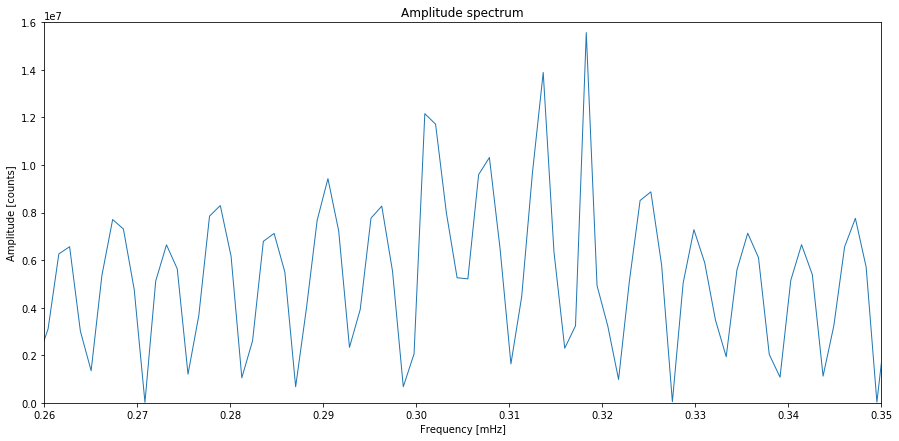

In [11]:
# Check the spectra for mode analysis
# We can use the station data when we see 5 peaks in the spectrogram

i = 1         # code number of station (from 0 to 138)
fNy = 1/2     # Nyquist Frequency is a half of sampling rate
print('station:', sta_fname1[i])

st = read(path.join(directory1, sta_fname1[i]),header=None)
tr_fft_check = st.copy()[0].data
freq = (np.linspace(0, fNy, len(tr_fft_check))) *1000  # to get mHz

# Plot the spectrum
plt.plot(freq, abs(tr_fft_check), lw=1)    
plt.title('Amplitude spectrum')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Amplitude [counts]')
plt.xlim (0.26, 0.35)
plt.ylim (0, 0.16E8)
plt.show()